<a href="https://colab.research.google.com/github/conel77/pytorchwikidocs_training/blob/main/animal_sorting_usingResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:

import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [ ]:
CFG = {
    'FPS':30,
    'IMG_SIZE':128,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':4,
    'SEED':41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import torchvision
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader

from torch.utils.data import Dataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np

from torch.optim.adam import Adam

In [ ]:
# transforms = Compose([
#     RandomCrop((32,32), padding=4),
#     RandomHorizontalFlip(p=0.5),
#     ToTensor(),
#     Normalize(mean=(0.4914, 0.4822, 0.4465), std =(0.247,0.243, 0.261))
# ])

In [ ]:
data =  torchvision.datasets.ImageFolder('drive/MyDrive/work/train_c', transform= transforms)

data_loader = DataLoader(data, batch_size=32, shuffle=True)


In [ ]:
data.class_to_idx

{'cats': 0, 'dogs': 1, 'horses': 2, 'humans': 3}

In [ ]:
class_names = data.classes


In [ ]:
train_size = int(0.8 * len(data))

test_size = len(data) - train_size


In [ ]:
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(train_data, batch_size=10,shuffle = True)


validation_loader = torch.utils.data.DataLoader(test_data, batch_size=10,shuffle = False)

tensor([3, 1, 2, 1, 3, 1, 0, 0, 0, 0])


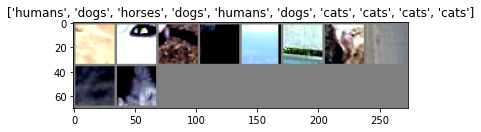

In [ ]:
inputs, classes = next(iter(train_loader))

print(classes)


def imshow(inp, title=None):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])

    std = np.array([0.5, 0.5, 0.5])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    if title is not None:

        plt.title(title)

    plt.pause(0.001) # pause a bit so that plots are updated

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## CustomDataset

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, files, labels, class_to_idx, transform):
        super(CustomImageDataset, self).__init__()
        self.files = files
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # file 경로
        file = self.files[idx]
        # PIL.Image로 이미지 로드
        img = Image.open(file).convert('RGB')
        # transform 적용
        img = self.transform(img)
        # label 생성
        label = self.class_to_idx[self.labels[idx]]
        # image, label return
        return img, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.CenterCrop((224, 224)),      # 중앙 Crop
    transforms.RandomHorizontalFlip(0.5),   # 50% 확률로 Horizontal Flip
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [ ]:
train_dataset = CustomImageDataset(train_data, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_data, val_labels, class_to_idx, test_transform)

In [ ]:
# class CustomDataset(torch.utils.data.Dataset): 
#     def __init__(self,df,path,option,augmentation=None):
#         self.df = df
#         self.option = option
#         self.augmentation = augmentation
#         self.path = path

#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, idx): 
#         file_path  = self.df.iloc[idx,0]
#         image=  Image.open(os.path.join(self.path,file_path)).convert('RGB')
        
#         image = np.array(image)
             
        
        
#         if self.augmentation is not None:
#             image = self.augmentation(image=image)['image']
        
        
#         if self.option =='train':
#             label = self.df.iloc[idx,1]
#             label = torch.tensor(label, dtype=torch.int64)
#             return image, label
        
#         return image

In [ ]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from torchvision import models # pretrained 모델을 가져오기 위한 import

# ResNet101 모델 생성
model = models.resnet101(pretrained=True) 

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
# 가중치를 Freeze 하여 학습시 업데이트가 일어나지 않도록 설정합니다.
for param in model.parameters():
    param.requires_grad = False  # 가중치 Freeze

In [ ]:
import torch.nn as nn


# Fully-Connected Layer를 Sequential로 생성하여 VGG pretrained 모델의 'Classifier'에 연결합니다.
fc = nn.Sequential(
    nn.Linear(2048, 256), # VGG16 모델의 features의 출력이 7X7, 512장 이기 때문에 in_features=7*7*512 로 설정합니다.
    nn.ReLU(), 
    nn.Linear(256, 64), 
    nn.ReLU(), 
    nn.Linear(64, 4),
)

In [ ]:
model.fc = fc
model.to(device)
# 모델의 구조도 출력
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, label in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, label = img.to(device), label.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, label)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(label).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [ ]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, label in data_loader:
            # device에 데이터를 올립니다.
            img, label = img.to(device), label.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(label)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, label).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [ ]:
# 최대 Epoch을 지정합니다.
num_epochs = 10
model_name = 'vgg16-pretrained'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, validation_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

 99%|█████████▉| 162/163 [00:39<00:00,  4.08it/s]


ValueError: ignored

## Model Define

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3):
    super(BasicBlock, self).__init__()

    #합성곱층 정의
    self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
    self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
    self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    #배치 정규화층 정의
    self.bn1 = nn.BatchNorm2d(num_features=out_channels)
    self.bn2 = nn.BatchNorm2d(num_features=out_channels)


    self.relu = nn.ReLU()
  def forward(self, x):
    #스킵 커넥션을 위해 초기 입력을 저장

    x_ = x
    
    #ResNet 기본 블럭에서 F(x) 구분

    x = self.c1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.c2(x)
    x = self.bn2(x)


    #합성곱의 결과와 입력의 채널 수를 맞춘다
    x_ = self.downsample(x_)

    #합성곱층의 결과와 저장해놨던 입력값을 더해준다(스킵 커넥션)
    x += x_
    x = self.relu(x)

    return x

In [ ]:
class ResNet(nn.Module):
  def __init__(self, num_classes=5):
    super(ResNet, self).__init__()

    #기본 블록
    self.b1 = BasicBlock(in_channels=3, out_channels=64)
    self.b2 = BasicBlock(in_channels=64, out_channels=128)
    self.b3 = BasicBlock(in_channels=128, out_channels=256)

    #풀링을 최댓값이 아닌 평균값으로 바꾼다.

    self.pool = nn.AvgPool2d(kernel_size=2, stride = 2)

    #분류기
    self.fc1 = nn.Linear(in_features=4096, out_features=2048)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(in_features=2048, out_features=512)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(in_features=512, out_features=num_classes)
    self.relu = nn.ReLU()
  def forward(self,x):
    #기본 블록과 풀링층 통과
    x = self.b1(x)
    x = self.pool(x)
    x = self.b2(x)
    x = self.pool(x)
    x = self.b3(x)
    x = self.pool(x)

    x = torch.flatten(x, start_dim=1)

    #분류기로 예측값 출력

    x = self.fc1(x)
    x = self.relu(x)
    
    x = self.fc2(x)
    x = self.relu(x)
    
    x = self.fc3(x)


    return x

## Train

## Run!!

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(num_classes= 4)
model.to(device)


ResNet(
  (b1): BasicBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b2): BasicBlock(
    (c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (b3): BasicBlock(
    (c1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
import tqdm
lr = 1e-4
optim = Adam(model.parameters(), lr=lr)

for epoch in range(30):
  iterator = tqdm.tqdm(train_loader)
  for data, label in iterator:

    #최적화를 위해 기울기를 최소화한다
    optim.zero_grad()

    #모델의 예측값
    preds = model(data.to(device))

    #손실 계산 및 역전파
    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()

    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "ResNet.pth")

  0%|          | 0/45 [00:00<?, ?it/s]

## Inference